# Emotion Classification with DistilBERT + LoRA


In [37]:
#!pip install --upgrade --no-cache-dir transformers==4.52.4 datasets peft accelerate evaluate scikit-learn matplotlib seaborn


In [38]:
from datasets import load_dataset
from transformers import AutoTokenizer


dataset = load_dataset("dair-ai/emotion")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


print("Dataset Sizes:")
for split in dataset:
    print(f"{split}: {len(dataset[split])} samples")


print("\nSample data from train split:")
for i in range(2):
    print(f"Example {i+1}:")
    print("Text:", dataset["train"][i]["text"])
    print("Label:", dataset["train"][i]["label"])
    print("Label Name:", dataset["train"].features["label"].int2str(dataset["train"][i]["label"]))
    print()

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
print(tokenized_dataset["train"].features)


Dataset Sizes:
train: 16000 samples
validation: 2000 samples
test: 2000 samples

Sample data from train split:
Example 1:
Text: i didnt feel humiliated
Label: 0
Label Name: sadness

Example 2:
Text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Label: 0
Label Name: sadness

{'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [39]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"]  
)

model = get_peft_model(base_model, lora_config)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.nn import CrossEntropyLoss

class MetricsLogger(TrainerCallback):
    def __init__(self, trainer, train_dataset):
        self.train_dataset = train_dataset
        self.trainer = trainer
        self.history = {
            "train_loss": [], "train_accuracy": [], "train_precision": [], "train_recall": [], "train_f1": [],
            "eval_loss": [], "eval_accuracy": [], "eval_precision": [], "eval_recall": [], "eval_f1": []
        }

    def on_epoch_end(self, args, state, control, **kwargs):
        
        train_preds = self.trainer.predict(self.train_dataset)
        logits = torch.tensor(train_preds.predictions)
        labels = torch.tensor(train_preds.label_ids)

        
        loss_fn = CrossEntropyLoss()
        train_loss = loss_fn(logits, labels).item()
        self.history["train_loss"].append(train_loss)

        
        preds = torch.argmax(logits, dim=1).numpy()
        self.history["train_accuracy"].append(accuracy_score(labels, preds))
        self.history["train_precision"].append(precision_score(labels, preds, average="weighted", zero_division=0))
        self.history["train_recall"].append(recall_score(labels, preds, average="weighted", zero_division=0))
        self.history["train_f1"].append(f1_score(labels, preds, average="weighted", zero_division=0))

        
        eval_metrics = self.trainer.evaluate()
        for key in ["eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]:
            self.history[key].append(eval_metrics[key])

        
        print(f"Epoch {int(state.epoch)}\tTrain Loss: {train_loss:.4f}\t"
              f"Val Loss: {eval_metrics['eval_loss']:.4f}\t"
              f"Acc: {eval_metrics['eval_accuracy']:.4f}\t"
              f"Prec: {eval_metrics['eval_precision']:.4f}\t"
              f"Rec: {eval_metrics['eval_recall']:.4f}\t"
              f"F1: {eval_metrics['eval_f1']:.4f}")


In [41]:
from transformers import TrainingArguments, Trainer
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir="./emotion_model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

metrics_logger = MetricsLogger(trainer, tokenized_dataset["train"])
trainer.add_callback(metrics_logger)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [42]:
trainer.train()
trainer.save_model("emotion_lora_model")
tokenizer.save_pretrained("emotion_lora_model")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.662034,0.761000,0.769215,0.761000,0.746261
2,No log,0.480834,0.832500,0.834564,0.832500,0.828999
3,No log,0.398073,0.864500,0.864519,0.864500,0.863322
4,No log,0.364122,0.877500,0.877875,0.877500,0.876590
5,No log,0.350245,0.884000,0.883706,0.884000,0.882940


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 1	Train Loss: 0.6362	Val Loss: 0.6620	Acc: 0.7610	Prec: 0.7692	Rec: 0.7610	F1: 0.7463


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 2	Train Loss: 0.4506	Val Loss: 0.4808	Acc: 0.8325	Prec: 0.8346	Rec: 0.8325	F1: 0.8290


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 3	Train Loss: 0.3656	Val Loss: 0.3981	Acc: 0.8645	Prec: 0.8645	Rec: 0.8645	F1: 0.8633


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 4	Train Loss: 0.3291	Val Loss: 0.3641	Acc: 0.8775	Prec: 0.8779	Rec: 0.8775	F1: 0.8766


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 5	Train Loss: 0.3152	Val Loss: 0.3502	Acc: 0.8840	Prec: 0.8837	Rec: 0.8840	F1: 0.8829


('emotion_lora_model/tokenizer_config.json',
 'emotion_lora_model/special_tokens_map.json',
 'emotion_lora_model/vocab.txt',
 'emotion_lora_model/added_tokens.json',
 'emotion_lora_model/tokenizer.json')

In [43]:
print("Final Train Metrics:")
for k in metrics_logger.history:
    if k.startswith("train"):
        print(f"{k}: {metrics_logger.history[k][-1]:.4f}")

print("\nFinal Validation Metrics:")
for k in metrics_logger.history:
    if k.startswith("eval"):
        print(f"{k}: {metrics_logger.history[k][-1]:.4f}")


Final Train Metrics:
train_loss: 0.3152
train_accuracy: 0.8902
train_precision: 0.8890
train_recall: 0.8902
train_f1: 0.8890

Final Validation Metrics:
eval_loss: 0.3502
eval_accuracy: 0.8840
eval_precision: 0.8837
eval_recall: 0.8840
eval_f1: 0.8829


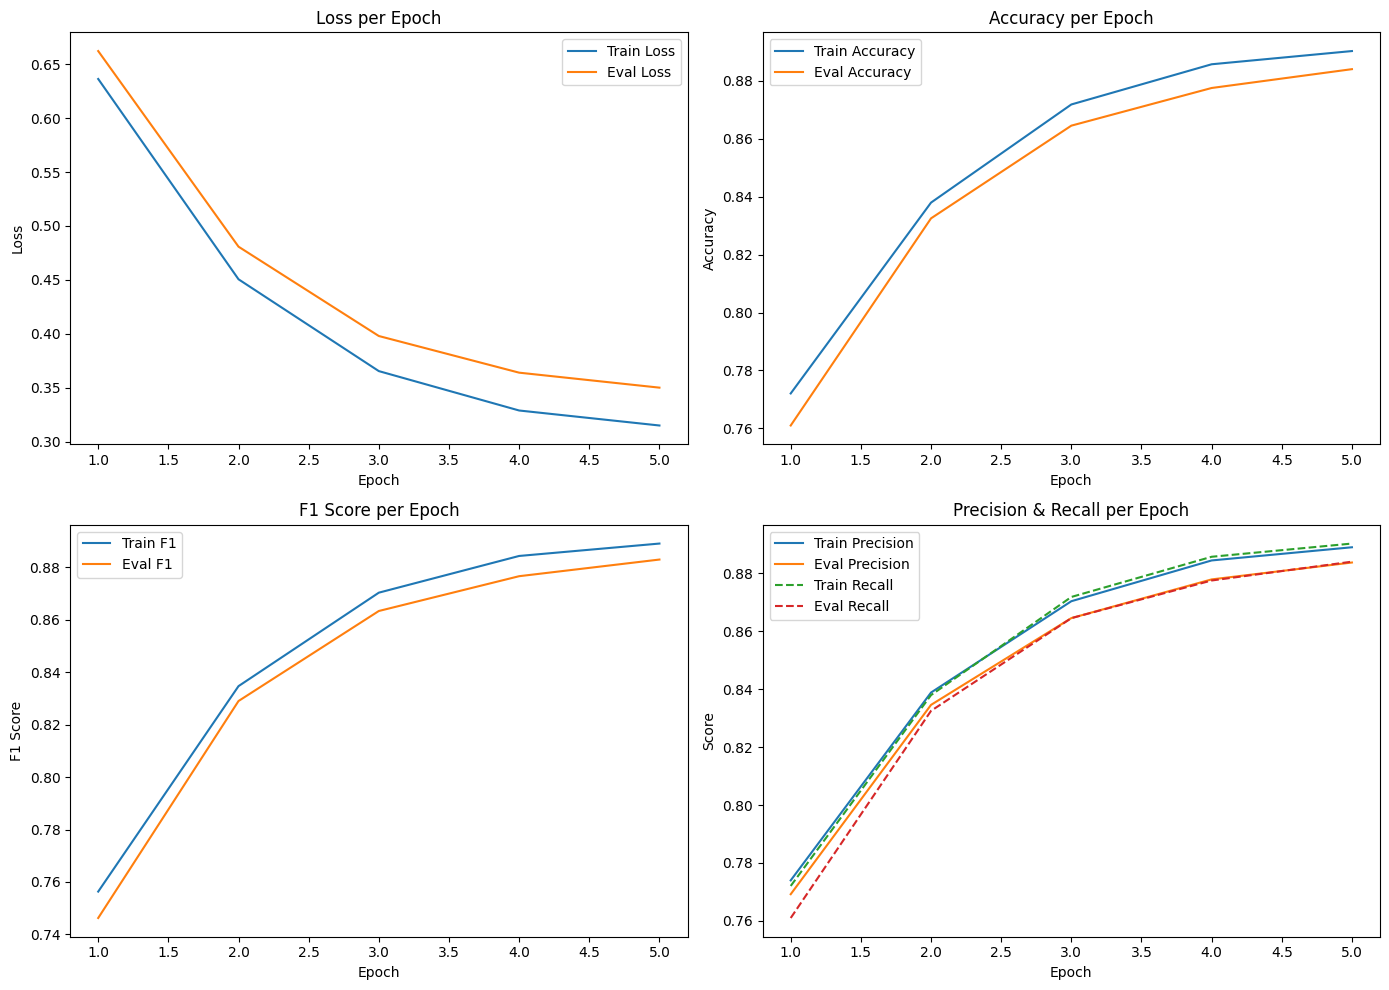

In [44]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(metrics_logger.history["train_loss"]) + 1))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, metrics_logger.history["train_loss"], label="Train Loss")
plt.plot(epochs, metrics_logger.history["eval_loss"], label="Eval Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, metrics_logger.history["train_accuracy"], label="Train Accuracy")
plt.plot(epochs, metrics_logger.history["eval_accuracy"], label="Eval Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, metrics_logger.history["train_f1"], label="Train F1")
plt.plot(epochs, metrics_logger.history["eval_f1"], label="Eval F1")
plt.title("F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, metrics_logger.history["train_precision"], label="Train Precision")
plt.plot(epochs, metrics_logger.history["eval_precision"], label="Eval Precision")
plt.plot(epochs, metrics_logger.history["train_recall"], label="Train Recall", linestyle="--")
plt.plot(epochs, metrics_logger.history["eval_recall"], label="Eval Recall", linestyle="--")
plt.title("Precision & Recall per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


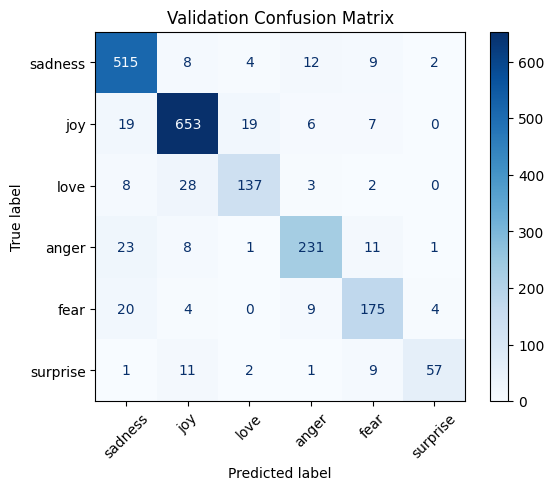

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

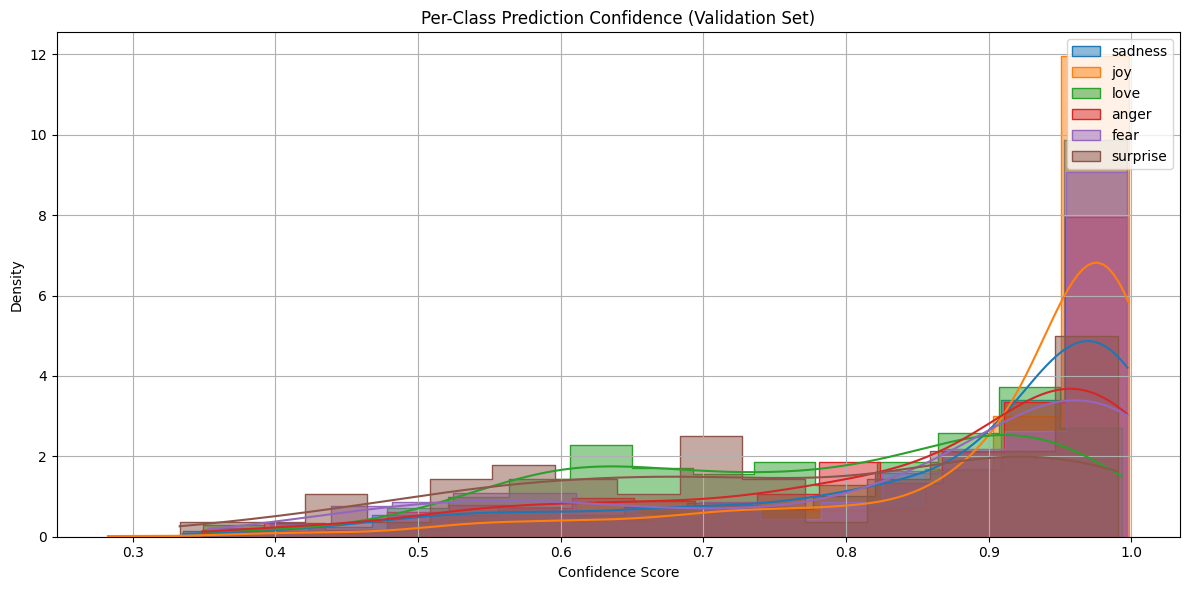

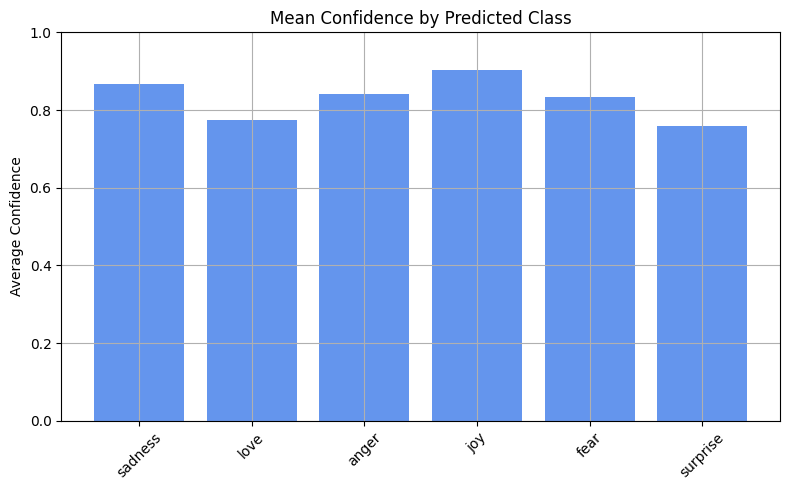

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import seaborn as sns
from collections import defaultdict

val_preds = trainer.predict(tokenized_dataset["validation"])
y_true = val_preds.label_ids
y_pred = np.argmax(val_preds.predictions, axis=1)


cm = confusion_matrix(y_true, y_pred)
class_names = dataset["train"].features["label"].names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Validation Confusion Matrix")
plt.show()


probs = torch.softmax(torch.tensor(val_preds.predictions), dim=1).numpy()
class_confidences = defaultdict(list)
for pred_class, prob_vector in zip(y_pred, probs):
    class_confidences[pred_class].append(np.max(prob_vector))

plt.figure(figsize=(12, 6))
for class_idx in sorted(class_confidences):
    sns.histplot(
        class_confidences[class_idx],
        kde=True,
        bins=15,
        label=class_names[class_idx],
        element="step",
        stat="density"
    )
plt.title("Per-Class Prediction Confidence (Validation Set)")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


means = {class_names[k]: np.mean(v) for k, v in class_confidences.items()}
plt.figure(figsize=(8, 5))
plt.bar(means.keys(), means.values(), color="cornflowerblue")
plt.title("Mean Confidence by Predicted Class")
plt.ylabel("Average Confidence")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import shutil


shutil.make_archive("emotion_lora_model", 'zip', "emotion_lora_model")


'/kaggle/working/emotion_lora_model.zip'